In [1]:
!pip install pandas

In [2]:
import os
from pyspark import SparkContext
from pyspark.sql import SparkSession
import findspark
import numpy as np
import pyspark
import pandas as pd
findspark.init()

### PRACTICAL ASSESSMENT TASK 2

#### 1. IMPLEMENTATION OF SERIALIZED K-MEANS (1 point)

serialReadFile: It receives a String filename Pandas dataframe with the loaded data.
with name of the csv file of the dataset. The function returns a

serialAssign2cluster: It receives a list of d-dimensional tuples called centroids, representing the current state
of the centroids, and a d-dimensional tuple x which represents the datum to be assigned to a cluster. It returns an
integer with the index in centroids of the closest centroid to x.
    
serialKMeans: Performs the serialized K-Means algorithm on the dataset X, grouping the instances into K different
clusters. The number of iterations of the method to be executed is n_iter. The initialization of the centroids will be
random, sampled from a standard normal distribution. It returns a list of length K with the d-dimensional centroids
computed.

In [4]:
# serial k-means from scratch

def serialReadFile(filename):
    current_directory = os.getcwd()
    data = pd.read_csv(current_directory + "/" + filename)
    return data

def serialAssign2cluster(x, centroids):
    
    ''' centroids = [(785 elements), (785 elements), ... ], 
    x = (785 elements)
    
    return: index of the closest cluster
    '''
    # how do i compute the distance between one element and the centroids?
    
    distances = [np.sqrt(np.sum((np.array(x) - np.array(c))**2)) for c in centroids]
    index = int(np.argmin(distances))
        
    return index

def serialKMeans(X, K, n_iter):
    
    ''' X is a pandas dataframe
    K number of clusters for grouping
    n_iter int

    return: labels updated
    '''
    X_array = X.values #using numpy for efficiency

    # centroids initialization
    centroids = [tuple(np.random.randn(X.shape[1])) for i in range(K)]
    labels = np.zeros(X.shape[0], dtype=int)

    for iteration in range(n_iter):
    
        for i in range(X.shape[0]):
            # assign each point to the closest cluster
            labels[i] = serialAssign2cluster(X_array[i], centroids)
    
        # updating the centroids coordinates
        new_centroids = np.zeros_like(centroids)
        for k in range(K):
            
            # points belonging to cluster k
            cluster_points = X_array[labels == k]
            if len(cluster_points) > 0:
                # mean along rows -> centroid coords
                new_centroids[k] = cluster_points.mean(axis=0) # each coordinate of the new centroid is the mean of the coordinates belonging to the cluster
            else:
                # if a cluster is empty, reinitialize its centroid
                new_centroids[k] = np.random.randn(X.shape[1])
                
        if np.allclose(np.array(centroids), np.array(new_centroids)):
            print(f"converged at iteration {iteration}")
            break
                
        centroids = new_centroids
        
    return labels, centroids

In [ ]:
labels, centroids = serialKMeans(X, 9, 200)

In [ ]:
accuracy = np.sum(labels == y) / len(y)
accuracy

In [ ]:
np.sum(labels == y)

#### 2. IMPLEMENTATION OF PARALLELIZED K-MEANS (4 points)

parallelReadFile: It receives a String filename with name of the csv file of the dataset. The function returns a
Spark RDD with the loaded data.

parallelAssign2cluster: It receives a list of d-dimensional tuples called centroids, representing the current
state of the centroids, and a d-dimensional tuple x which represents the datum to be assigned to a cluster. It returns
an integer with the index in centroids of the closest centroid to x.

parallelKMeans: Performs the parallelized K-Means algorithm on the RDD dataset data, grouping the
instances into K different clusters. The number of iterations of the method to be executed is n_iter. The
initialization of the centroids will be random, sampled from a standard normal distribution. It returns a list of
length K with the d-dimensional centroids computed.

In [5]:
# parallel k-means from scratch

from pyspark import SparkContext

def is_header(line):
    # Check if the line is a header by a known header feature (e.g., 'label')
    if line.startswith("label"):
        return []
    else:
        return [line]


def convert_to_float(line):
    # Convert all elements except the first one (label) to float and return as a list
    return [float(x) for x in line.split(",")[1:]]


def parallelReadFile(filename):
    """
    Reads a CSV file into an RDD, dropping the first row (header) and the first column (label).

    Parameters:
    filename : str
        The path to the CSV file.

    Returns:
    RDD
        An RDD of data points, where each data point is represented as a list of floats, excluding the label.
    """

    # Get an existing SparkContext or create a new one
    sc = SparkContext.getOrCreate()

    # Read the file into an RDD
    current_directory = os.getcwd()
    path = current_directory + "/" + filename
    data = sc.textFile(path)

    # Filter out the header and convert the rest of the lines to float arrays
    processed_data = data.flatMap(is_header).map(convert_to_float)

    return processed_data

In [7]:
def serialAssign2cluster(x, centroids):
    
    ''' centroids = [(785 elements), (785 elements), ... ], 
    x = (785 elements)
    
    return: index of the closest cluster
    '''
    # how do i compute the distance between one element and the centroids?
    x = np.array(x)
    distances = [np.sqrt(np.sum((np.array(x) - np.array(c))**2)) for c in centroids]
    index = np.argmin(distances)
        
    return index

In [52]:
def initialize_centroids_kmeans_pp(X_rdd, K):
    """
    K-means++ initialization: spread centroids far apart.
    """
    # Collect data (if dataset is small enough)
    X = np.array(X_rdd.collect())
    
    # Choose first centroid randomly
    centroids = [X[np.random.randint(len(X))]]
    
    for _ in range(1, K):
        # Compute distance of each point to nearest centroid
        distances = np.array([min([np.linalg.norm(x - c) for c in centroids]) for x in X])
        
        # Choose next centroid with probability proportional to distance²
        probs = distances ** 2
        probs /= probs.sum()
        next_centroid = X[np.random.choice(len(X), p=probs)]
        centroids.append(next_centroid)
    
    return np.array(centroids)

In [8]:
def parallelKMeans(X_rdd, K, n_iter, tol = 1e-4):
    
    ''' X is a pandas dataframe
    K number of clusters for grouping
    n_iter int

    return: labels updated
    '''
    
    sc = X_rdd.context

    # 784 features for each point
    num_features = len(X_rdd.first())

    # keeping centroids in the driver

    #k++ initialization
    # centroids = initialize_centroids_kmeans_pp(X_rdd, K)

    #random initialization
    centroids = np.random.randn(K, num_features)
    # in this case i won't store a label vector on driver but recomputing the label every time

    for iteration in range(n_iter):
        # broadcasting centroids to all workers
        bc_centroids = sc.broadcast(centroids)
    
        # mapping each point to the closest centroid using map.
        # (centroidID, point)
        point_assignment = X_rdd.map(
        lambda point: (
        serialAssign2cluster(np.array(point), bc_centroids.value),  
        np.array(point)  
        ))
    
        # computing the sum and count for each cluster to update the centroids 
        
        cluster_stats = point_assignment.mapValues(
        lambda point: (point, 1)
        ).reduceByKey(
            lambda a, b: (a[0] + b[0], a[1] + b[1])
        ).collect()

        # here i dont need the old centroids anymore so i clean the broadcast
        bc_centroids.unpersist()

        new_centroids = np.zeros_like(centroids)
        
        # updating centroids
        for cluster_id, (point_sum, count) in cluster_stats:
            if count > 0:
                new_centroids[cluster_id] = point_sum / count
            else:
                # Reinitialize empty cluster
                new_centroids[cluster_id] = np.random.randn(num_features)
        
        # there might be some clusters with no points assigned

        assigned_clusters = set(cluster_id for cluster_id, _ in cluster_stats)
        for k in range(K):
            if k not in assigned_clusters:
                new_centroids[k] = np.random.randn(num_features)

        
        if np.allclose(np.array(centroids), np.array(new_centroids)):
            print(f"converged at iteration {iteration}")
            break
                
        centroids = new_centroids

    # Final assignment to get labels
    bc_centroids = sc.broadcast(centroids)
    
    labels = X_rdd.map(
        lambda point: serialAssign2cluster(np.array(point), bc_centroids.value)
    ).collect()
    bc_centroids.unpersist()
        
    return np.array(labels), centroids

In [39]:
import matplotlib.pyplot as plt

def plot_centroids(centroids):
    """
    Plot a 784-dimensional vector as a 28x28 image.
    
    Args:
        vector: numpy array of 784 elements (flattened MNIST image)
    """
    K = len(centroids)
    cols = min(5, K)  # Max 5 columns
    rows = (K + cols - 1) // cols  # Calculate needed rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten() if K > 1 else [axes]
    
    for i, (centroid, label) in enumerate(zip(centroids, labels)):
        axes[i].imshow(centroid.reshape(28, 28), cmap='gray')
        axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(K, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
# documentation to expalain transformations

# RDD of (cluster_id, point)

# point_assignment = X_rdd.map(lambda point: (serialAssign2cluster(np.array(point), bc_centroids.values), bc_centroids.values)) 
[
    (0, array([1.0, 2.0])),
    (1, array([5.0, 6.0])),
    (0, array([1.5, 2.5])),
    (1, array([5.5, 6.5])),
    (0, array([1.2, 2.2]))
]

# After mapValues (cluster_id, (point, 1)), add 1 to each point to count them

# point_assignment_stage2 = point_asignment.mapValues(lambda point: (point, 1))

[
    (0, (array([1.0, 2.0]), 1)),
    (1, (array([5.0, 6.0]), 1)),
    (0, (array([1.5, 2.5]), 1)),
    (1, (array([5.5, 6.5]), 1)),
    (0, (array([1.2, 2.2]), 1))
]

# now i want to sum counts and points of grouped by clusters, I'll do that using reduceByKey where the key is the clusterID
# remember key = 0 value = (array([1.0, 2.0]), 1)
# point_assignment_stage3 = point_asignment2.reduceByKey(lambda a, b: a[0] + b[0], a[1] + b[1])

# and this is the final result after collecting

cluster_stats = [
    (0, (array([3.7, 6.7]), 3)),  # cluster 0: sum and count
    (1, (array([11.0, 13.0]), 2))  # cluster 1: sum and count
]

In [ ]:
labels, clusters = parallelKMeans(X, 10, 10)
print("Labels:", labels)
print("Centroids:\n", clusters)

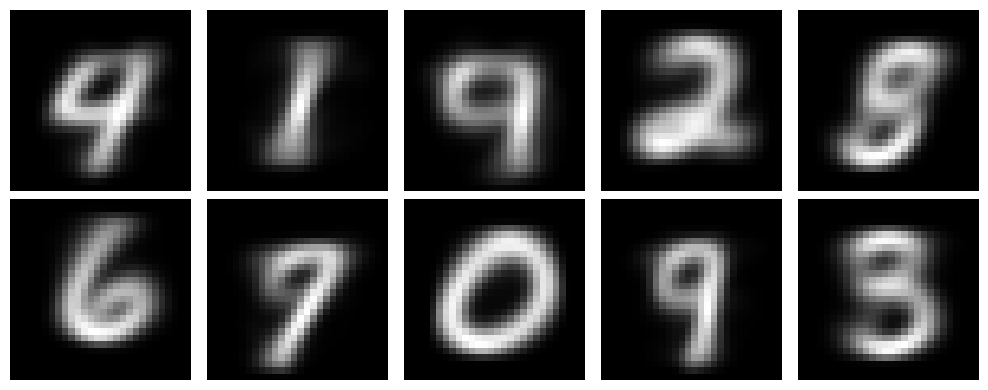

In [20]:
plot_centroids(clusters)

#### 3. ANALYSIS AND DISCUSSION (5 points)
Using the aforementioned version of the parallelized K-Means algorithm, analyze the execution time of the
proposed solution on the MNIST dataset uploaded to Moodle. This dataset contains 70,000 samples of handwritten
digits, from 0 to 9. Each image is represented by a 28 × 28 matrix of black-and-white pixels. In the dataset, this pixel
matrix has been flattened into a 28 × 28 = 784 vector, so the dataset contains 28000 rows and 784 columns. Each pixel
is represented by an integer ranging from 0 (white pixel) to 255 (black pixel).


=== Iteration 1 ===
Master: local[1]
Default Parallelism: 1
App Name: KMeans_1_cores
start time 1764329766.3686736
Number of data partitions: 1


25/11/28 11:36:15 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764329991.5637324

=== Iteration 2 ===
Master: local[2]
Default Parallelism: 2
App Name: KMeans_2_cores
start time 1764329994.5311296
Number of data partitions: 1


25/11/28 11:39:59 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764330110.6683574

=== Iteration 3 ===
Master: local[3]
Default Parallelism: 3
App Name: KMeans_3_cores
start time 1764330113.643914
Number of data partitions: 2


25/11/28 11:41:59 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764330197.1950116

=== Iteration 4 ===
Master: local[4]
Default Parallelism: 4
App Name: KMeans_4_cores
start time 1764330200.1725838
Number of data partitions: 3


25/11/28 11:43:24 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764330275.0653794

=== Iteration 5 ===
Master: local[5]
Default Parallelism: 5
App Name: KMeans_5_cores
start time 1764330278.0425892
Number of data partitions: 4


25/11/28 11:44:42 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764330341.5120382

=== Iteration 6 ===
Master: local[6]
Default Parallelism: 6
App Name: KMeans_6_cores
start time 1764330344.4751587
Number of data partitions: 5


25/11/28 11:45:48 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764330400.8179955

=== Iteration 7 ===
Master: local[7]
Default Parallelism: 7
App Name: KMeans_7_cores
start time 1764330403.7831373
Number of data partitions: 6


25/11/28 11:46:47 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764330460.2837865

=== Iteration 8 ===
Master: local[8]
Default Parallelism: 8
App Name: KMeans_8_cores
start time 1764330463.2432175
Number of data partitions: 7


25/11/28 11:47:47 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764330517.7494922

=== Iteration 9 ===
Master: local[9]
Default Parallelism: 9
App Name: KMeans_9_cores
start time 1764330520.7193105
Number of data partitions: 8


25/11/28 11:48:45 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764330577.7421842

=== Iteration 10 ===
Master: local[10]
Default Parallelism: 10
App Name: KMeans_10_cores
start time 1764330580.7169137
Number of data partitions: 9


25/11/28 11:49:44 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764330644.3846195

=== Iteration 11 ===
Master: local[11]
Default Parallelism: 11
App Name: KMeans_11_cores
start time 1764330647.3588595
Number of data partitions: 10


25/11/28 11:50:51 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764330716.161503

=== Iteration 12 ===
Master: local[12]
Default Parallelism: 12
App Name: KMeans_12_cores
start time 1764330719.1366007
Number of data partitions: 11


25/11/28 11:52:04 WARN BlockManager: Task 4 already completed, not releasing lock for rdd_6_0
                                                                                

end time 1764330780.6427794


ValueError: cannot reshape array of size 70000 into shape (28,28)

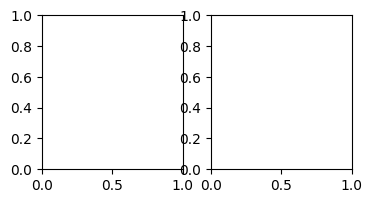

In [25]:
import time
import pyspark


os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

execution_times = []
speed_up = []

# Stop any existing context before the loop
try:
    existing_sc = pyspark.SparkContext._active_spark_context
    if existing_sc:
        existing_sc.stop()
        time.sleep(1)  # Give it time to fully stop
except:
    pass

    
for i in range(1,4):
    
    number_cores = i
    
    conf = (
        pyspark.SparkConf()
        .setMaster('local[{}]'.format(number_cores))
        .setAppName('KMeans_{}_cores'.format(number_cores))
    )
    
    sc = pyspark.SparkContext(conf=conf)

    # Print the actual configuration
    print(f"\n=== Iteration {i} ===")
    print(f"Master: {sc.master}")
    print(f"Default Parallelism: {sc.defaultParallelism}")
    print(f"App Name: {sc.appName}")
    
    
    # read data
    data = parallelReadFile('mnist_dataset.csv')
    # optimize performance

    data = data.repartition(number_cores)
    print(f"Number of data partitions: {data.getNumPartitions()}")
    
    data_cache = data.cache()
    
    start_time = time.time()
    print("start time", start_time)
    
    centroids = parallelKMeans(data_cache, 10, 10)
    end_time = time.time()
    execution_times.append(end_time - start_time)
    
    print("end time", end_time)
    print("time needed", end_time - start_time)
    
    sc.stop()
    time.sleep(2)
    


In [28]:
num_workers = list(range(1, len(execution_times)+1))

3.1 (2 points) Study the execution time of the K-Means algorithm on the MNIST dataset versus the number of
parallel workers and prepare plots showing:
(i) The performance curve (the execution time (y axis) versus the number of workers (x axis) using different
values of K.
(ii) The speedup ratio (running time using

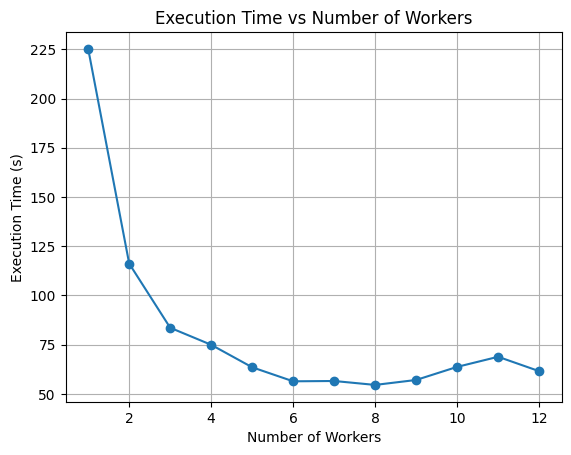

In [29]:
plt.plot(num_workers, execution_times, marker='o', linestyle='-')
plt.xlabel('Number of Workers')  # Label for x-axis
plt.ylabel('Execution Time (s)')  # Label for y-axis
plt.title('Execution Time vs Number of Workers')  # Title for the plot
plt.grid(True)  # Show grid lines
plt.show()

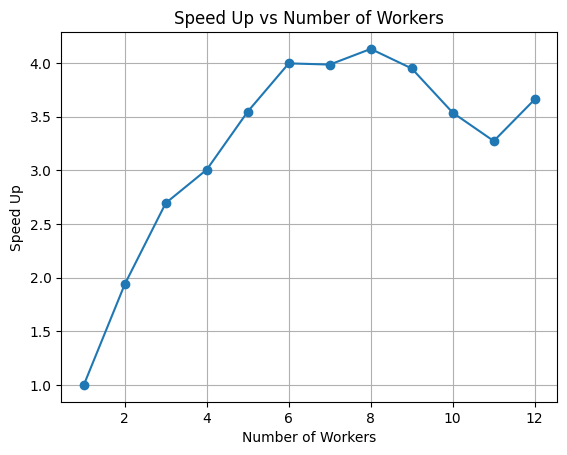

In [30]:
for i in range(0,len(execution_times)):
    speed_up.append(execution_times[0]/execution_times[i])
plt.plot(num_workers, speed_up, marker='o', linestyle='-')
plt.xlabel('Number of Workers')  # Label for x-axis
plt.ylabel('Speed Up')  # Label for y-axis
plt.title('Speed Up vs Number of Workers')  # Title for the plot
plt.grid(True)  # Show grid lines
plt.show()

3.2 (1 point) Analyze the impact of parallelizing other parts of the algorithm as the computations of distances of an
instance to each of the centroids. Plot the performance and speedup curves using different values of K and compare the
results with respect the ones obtained in 3.1

In [ ]:
# to do

3.3 (0.5 points) Analyze and interpret the obtained clusters with K = 3, 5, 7, 8, 9, 10 and 11. Show plots of the
obtained centroids and relate them with the original data.

25/11/28 12:06:40 WARN BlockManager: Task 0 already completed, not releasing lock for rdd_2_0
[Stage 17:==============>                                           (1 + 3) / 4]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


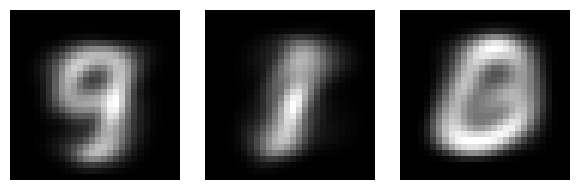

25/11/28 12:07:20 WARN BlockManager: Task 69 already completed, not releasing lock for rdd_2_0
[Stage 35:==============>                                           (1 + 3) / 4]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


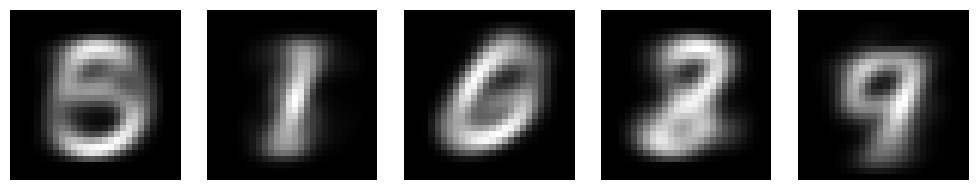

In [37]:
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# Stop any existing context before the loop
try:
    existing_sc = pyspark.SparkContext._active_spark_context
    if existing_sc:
        existing_sc.stop()
        time.sleep(1)  # Give it time to fully stop
except:
    pass

execution_times = []
speed_up = []

# Set K values
k_values = [3, 5, 7, 8, 9, 10, 11]  # Replace with the K values you want to test

conf = (
        pyspark.SparkConf()
        .setMaster('local[{}]'.format(number_cores))
        .setAppName('KMeans_{}_cores'.format(number_cores))
    )
sc = pyspark.SparkContext(conf=conf)
# read data
data = parallelReadFile('mnist_dataset.csv')
# optimize performance
data_cache = data.cache()

# using 8 cores from the previous experiment
for i in k_values:
    start_time = time.time()
    _, centroids = parallelKMeans(data_cache, i, 8)
    print(centroids)
    plot_centroids(centroids)
    end_time = time.time()
    execution_times.append(end_time - start_time)

3.4 Writing the report